# Análisis inicial del conjunto de datos

## Introducción

En `./datos/HT_Sensor*.dat` se tiene el conjunto de datos original, separado en un fichero de atributos y otro de meta-atributos. El dataset describe medidas de un sensor de olores, caracterizado por un conjunto de resistencias y un medidor de temperatura y humedad del ambiente. Cada medida se puede representar de la siguiente forma:

<a href="https://imgur.com/3yPLKHa"><img src="https://i.imgur.com/3yPLKHa.png" title="source: imgur.com" width="700"/></a>

**Figura 1**. Medida del dataset
Figura extraída de https://arxiv.org/pdf/1608.01719.pdf

A la izquierda de la línea azul todavía no se ha comenzado la inducción (acercar el estímulo al sensor); esto viene representado en el conjunto de datos con tiempos (atributo 'time') negativos. Cuando se llega a la segunda línea azul, se retira el estímulo; esto viene representado en el conjunto de datos por aquellos tiempos (atributo 'time) mayores que el atributo 'dt' correspondiente en el conjunto de metadatos.

## Transformación de los datos a una situación realista

Típicamente, el sensor evaluaría cada cierto tiempo $t_1$ las estadísticas de los atributos en el último tiempo $t_2$; por ejemplo, cada 30 segundos evaluar las estadísticas de los atributos en los últimos 60 segundos.

Suponiendo que transformamos el conjunto de datos para que trabaje con dichos empaquetados, una forma de hacerlo es, dada una medida $M$ con un tiempo inicial $t_i$, un tiempo final $t_f$, con una frecuencia de evaluación del sensor $t_p$ y un rango del historial $n_h$: 

- Dividir el intervalo en $\frac{t_f - t_i}{t_p}$ subintervalos.
- Para cada subintervalo, crear un paquete con las muestras que entran en dicho intervalo de tiempo y en los últimos $n_h$ intervalos de tiempo.

Por ejemplo, si $t_p=30$ y $n_h=5$, cada 30 segundos, se crearía un paquete con las muestras de los últimos 150 segundos, de esta manera, a partir de los datos se simula una situación en la que el sensor debe clasificar en tiempo real.

El problema es el etiquetado de cada paquete: cuándo decimos que tenemos un estímulo y cuándo decimo que el paquete representa 'background' (sin estímulo). Hay muchas maneras de plantearlo, pero viendo las gráficas de arriba, se ve que los cambios en los sensores no son inmediatos ante el estímulo, por lo que no puede usarse solamente la clase de la última muestra para clasificar el paquete, aunque sin duda, tiene una más importancia que el resto del historial (especialmente en el caso del vino). La elección que se ha tomado es un voto ponderado de las muestras, donde el peso de cada muestra decrece linealmente; es decir, si tenemos las muestras $[m_1, m_2, m_3, m_4, m_5]$, etiquetadas como background o estímulo en función de si quedan a la izquierda o derecha de la línea azul, por ejemplo $[background, background, background, background, wine]$, los pesos serían $[1/15, 2/15, 3/15, 4/15, 5/15]$ (el denominador se calcula como $\frac{n(n+1)}{2}$), y habría una mayoría de background, en cambio, con tener una muestra más de vino: $[background, background, background, vino, vino]$, habría una mayoría de vino, ya que las últimas dos muestras tienen más peso.

La función `crear_dataframe_treal` realiza todos este proceso, donde se recibe una serie de funciones de agregación estadísticas para cada paquete (mínimo, media, etc.), la frecuencia a la que el sensor tomaría cada medida y finalmente, cuantos períodos de historial tiene cada medida ($n_h$ en la explicación anterior). La función persiste el resultado en un csv.


A continuación, se muestra cómo crear el conjunto de datos en tiempo real. Para nuestro conjunto de tiempo real, hemos usado una frecuencia de medida de 60 segundos con un historial de 2, es decir, cada 60 segundos evaluar las estadísticas de los sensores de los últimos 120 segundos, estos parámetros se han tanteado en función de la figura 1.

In [12]:
import transformacion_datos

# Basta con ejecutar esto una sola vez para persistir el resultado
# Parametros
# funciones_agregacion = ['min', 'max', 'sum', 'mean', 'median', 'std', 'var', 'sem']
# crear_dataframe_treal(funciones_agregacion=funciones_agregacion)

# Obtener como array numpy, cuyas columnas originales tienen la descripción cols
X, y, cols = transformacion_datos.csv_a_numpy(transformacion_datos.DATA_TEST_DEFAULT_PATH)
print('Datos: ')
print(X)
print('Columnas: ')
print(cols)
print('Clases: ')
print(y)

Datos: 
[[1.27501000e+01 1.27547000e+01 1.51748390e+03 ... 3.36039448e-02
  1.12922510e-03 3.08046857e-03]
 [1.21311000e+01 1.24380000e+01 1.46013120e+03 ... 1.18873249e-01
  1.41308492e-02 1.08515933e-02]
 [1.25684000e+01 1.26222000e+01 1.49972580e+03 ... 6.11906106e-02
  3.74429083e-03 5.60933408e-03]
 ...
 [1.31093000e+01 1.31220000e+01 1.57392920e+03 ... 1.46585810e-01
  2.14873998e-02 1.33813925e-02]
 [1.29103000e+01 1.29177000e+01 1.53691670e+03 ... 9.65541382e-03
  9.32270161e-05 8.85110334e-04]
 [1.23286000e+01 1.23622000e+01 1.46895480e+03 ... 7.53836792e-02
  5.68269909e-03 6.91041054e-03]]
Columnas: 
['R1_min', 'R1_max', 'R1_sum', 'R1_mean', 'R1_median', 'R1_std', 'R1_var', 'R1_sem', 'R2_min', 'R2_max', 'R2_sum', 'R2_mean', 'R2_median', 'R2_std', 'R2_var', 'R2_sem', 'R3_min', 'R3_max', 'R3_sum', 'R3_mean', 'R3_median', 'R3_std', 'R3_var', 'R3_sem', 'R4_min', 'R4_max', 'R4_sum', 'R4_mean', 'R4_median', 'R4_std', 'R4_var', 'R4_sem', 'R5_min', 'R5_max', 'R5_sum', 'R5_mean', 'R5

## Procedimiento de selección de un clasificador

El siguiente diagrama muestra cómo se evaluarán y seleccionarán los mejores modelos:

<a href="https://imgur.com/1uRiJTs"><img src="https://i.imgur.com/1uRiJTs.png" title="source: imgur.com" /></a>

## Uso de un arbol de decisión para clasificar el conjunto.

Primero, hemos probado a buscar los mejores hiperparámetros usando un árbol de decisión, para ello, se ha hecho un grid_search, optimizando la precisión, que es $\frac{True Positives}{True Positives + False Positives}$ en vez de simplemente el optimizar el error. Esto se debe a que gran parte de los datos son background (aproximadamente el 80%), por lo que es muy fácil para el clasificador decir que todo es background y quedarse satisfecho con un 20% de error. Nosotros queremos minimizar el caso de decir que wine o banana es background, por lo que usamos 'precision'.

Los parámetros utilizados para la búsqueda son:
- 20% de test para validar la selección.
- 80% de train para buscar hiperparámetros, en cada caso se hace un k-fold con k=10.
- varios hiperparámetros a probar del árbol de decisión.

In [13]:
from sklearn.tree import DecisionTreeClassifier

transformacion_datos.grid_search(X, y, 0.20, ['precision'], DecisionTreeClassifier,
            {
                'splitter': ['best'],
                'max_depth': [None] + list(range(2, 5)),
                'min_samples_split': list(range(2, 5)),
                'min_samples_leaf': list(range(1, 5)),
                'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
                'max_features': [None, 10, 12, 15],
                'max_leaf_nodes': [None],
                'min_impurity_decrease': [0.0, 0.1, 0.2],
                'ccp_alpha': [0.0, 0.05, 0.1]
            })

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

  background       0.95      0.95      0.95      2518
      banana       0.69      0.70      0.69       253
        wine       0.78      0.79      0.78       391

    accuracy                           0.91      3162
   macro avg       0.81      0.81      0.81      3162
weighted avg       0.91      0.91      0.91      3162




Como se ve arriba, ha ocurrido uno de los problemas pronosticados, background tiene mucha precisión, pero el resto es algo mediocre. Si creamos un clasificador con los hiperparámetros seleccionados, veremos que al hacer k-fold se obtiene un error muy bueno, pero si vemos una matriz de confusión, descubriremos que gran parte del éxito se debe a que se clasifican bien los background, que es la clase mayoritaria. Obsérvese que la matriz de confusión clasifica mejor vino que plátano (en las gráficas se ve el motivo: el vino causa mucho más ruido) y que la mayor parte del error se debe a indicar que algo es background y no lo es y al reves.

También se aprecia en el árbol que o la relación entre los atributos es compleja o hay mucho overfitting, pero teniendo en cuenta cómo se han seleccionado los hiperparámetros, podría tratarse del primer caso.

Error de árbol de decisión: 8.313377208784711%
Desviación típica del error: 0.740348964369037
Representación del árbol entrenado con uno de los folds:


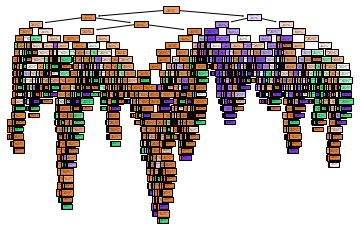

Matriz de confusión del clasificador: 


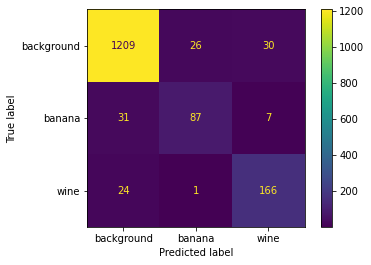

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

clf_tree = DecisionTreeClassifier(**{'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'})
res = cross_val_score(clf_tree, X_train, y_train, cv=10, n_jobs=-1)
print(f'Error de árbol de decisión: {(1-np.mean(res))*100}%')
print(f'Desviación típica del error: {np.std(res)*100}')
print('Representación del árbol entrenado con el conjunto de train:')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
clf_tree.fit(X_train, y_train)
plt.figure()
plot_tree(clf, filled=True, feature_names=cols)
plt.show()
print('Matriz de confusión del clasificador: ')
plot_confusion_matrix(clf_tree, X_test, y_test)
plt.show()
print(f'Error del clasificador: {(1-clf_tree.score(X_test, y_test))*100}%')

## Uso de SVM para clasificar el conjunto.

Las SVM suelen dar buenos resultados, pero son bastante lentas, pues el tiempo que tardan crece cuadráticamente con el tamaño de la entrada. Una buena forma de utilizarlos es entrenando subconjuntos de la entrada seleccionados con Bagging para generar un conjunto de clasificadores con los que se hace un voto por mayoría (One vs Rest). 


Debido a que el clasificador es muy lento, hacer grid search se hace inviable, por lo que hay que adivinar los mejores hiperparámetros: al haber muchas más muestras de background, conviene ajustar bien los pesos de las clases, se prueba con: pesos equivalentes y por algoritmo de sklearn (más prioridad a clases minoritarias).

### Equivalencia de pesos en las clases

Como se ve, el error no es muy alto, pero literalmente la decisión del clasificador es constante y no sirve para nada. Por supuesto esto se debe a que no se le da suficiente importancia a las muestras que no sean background.
 

Matriz de confusión del clasificador: 


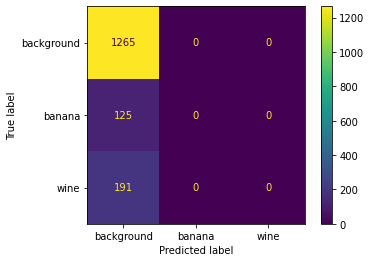

Error del clasificador: 19.987349778621123%


In [58]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

n_clfs = 200
clf_svm = OneVsRestClassifier(BaggingClassifier(SVC(kernel='rbf', class_weight=None), max_samples=(1.0 / (n_clfs / 16)), n_estimators=n_clfs, n_jobs=-1), n_jobs=-1)
clf_svm.fit(X_train, y_train)
print('Matriz de confusión del clasificador: ')
plot_confusion_matrix(clf_svm, X_test, y_test)
plt.show()
print(f'Error del clasificador: {(1-clf_svm.score(X_test, y_test))*100}%')

### Pesos balanceados



Matriz de confusión del clasificador: 


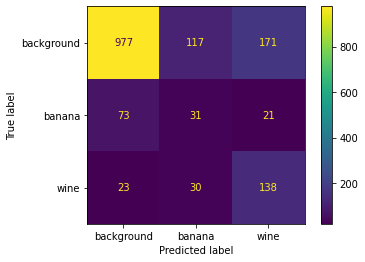

Error del clasificador: 27.514231499051235%


In [56]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
n_clfs = 200
clf_svm = OneVsRestClassifier(BaggingClassifier(SVC(kernel='rbf', class_weight='balanced'), max_samples=(1.0 / (n_clfs / 32)), n_estimators=n_clfs, n_jobs=-1), n_jobs=-1)
clf_svm.fit(X_train, y_train)
print('Matriz de confusión del clasificador: ')
plot_confusion_matrix(clf_svm, X_test, y_test)
plt.show()
print(f'Error del clasificador: {(1-clf_svm.score(X_test, y_test))*100}%')

## Uso de boosting para clasificar el conjunto.

En base a los resultados del árbol de decisión y a la estrucura del conjunto de datos, boosting puede ser una muy buena opción, ya que claramente uno de los grandes problemas es la gran cantidad de muestras de background, por lo que al equivocarse con las otras clases debido a background y aumentar el peso de dichas muestras este problema debería mitigarse, pues se le dedicará más atención a las muestras problemáticas.

En cuanto a los hiperparámetros, tampoco se puede hacer grid_search, pues el proceso no es muy rápido. Como hay muchos atributos, se poda a profundidad 6 (logaritmo del número de atributos) como heurística de la profundidad máxima apropiada. Generalmente el algoritmo mejor con más clasificadores, por lo que se han utilizado también bastantes. Como en este caso realmente las diferencias que marcan una clase u otra son sutiles, se permite un learning_rate constante, que típicamente se utiliza para dar cada vez menos importancia a los sucesivos clasificadores para evitar overfitting.

A continuación se muestran los resultados con dicho clasificador:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

clf_boosting = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=6)
res = cross_val_score(clf_boosting, X_train, y_train, cv=10, n_jobs=-1)
print(f'Error de boosting: {(1-np.mean(res))*100}%')
print(f'Desviación típica del error: {np.std(res)*100}')
clf_boosting.fit(X_train, y_train)
print('Matriz de confusión del clasificador: ')
plot_confusion_matrix(clf_boosting, X_test, y_test)
plt.show()
print(f'Error del clasificador: {(1-clf_boosting.score(X_test, y_test))*100}%')

Análisis de la celda de arriba

## Conclusiones

...